In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [5]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/ps_mask_0.8deg/"

In [6]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure 
nfw_smoothed = np.load('/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy')[10]*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')
ps_mask_0p8 = np.load('/tigress/ljchang/NPTF-IG-Check/data/mask_3fgl_0p8deg.npy')


In [7]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif_bf = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso_bf = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc_bf = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub_bf = np.load(templates_dir+"bub_band_2_ring_30.npy")
# dsk_bf = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [8]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

In [9]:
from scipy.stats import chi2

def poiss_err(n,ntrue,alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3

    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = chi2.ppf(alpha/2,2*n)/2+ntrue
    sigma_up = chi2.ppf(1-alpha/2,2*(n+1))/2+ntrue

#     sigma = (2*sigma_lo*sigma_up)/(sigma_lo+sigma_up)
#     sigma_prime = (sigma_up-sigma_lo)/(sigma_lo+sigma_up)

    return sigma_lo, sigma_up

In [10]:
GCE_options = [0,1]
GCE_tags = ["","_with_GCE_ps"]

In [11]:
def dNdF_1break(A,n1,n2,Fb1,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    else:
        return A*(F/Fb1)**(-n2)
    
def dNdF_2break(A,n1,n2,n3,Fb1,Fb2,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    elif F >= Fb2:
        return A*(F/Fb1)**(-n2)
    else:
        return A*(Fb2/Fb1)**(-n2)*(F/Fb2)**(-n3)

In [12]:
smoothed_nfw = np.load("/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")

In [13]:
Jfac_map_NFW = smoothed_nfw[10]

In [14]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

In [15]:
sims_dir = "/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/"

In [16]:
f_ary0 = np.logspace(-13,-8,100)

In [17]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

/tigress/ljchang/heptools/anaconda3/envs/venv_NPTF/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


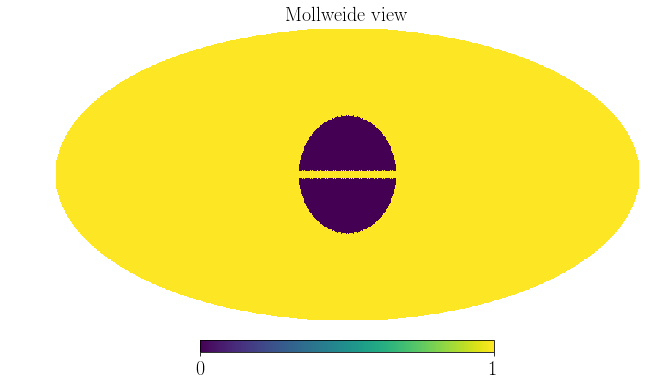

In [18]:
hp.mollview(analysis_mask_base)

In [19]:
# true_dif, true_

In [20]:
mask_0p8deg = 1
if mask_0p8deg:
    analysis_mask = analysis_mask_base + ps_mask_0p8
    analysis_mask = analysis_mask > 0 
else:
    analysis_mask = analysis_mask_base + ps_mask
    analysis_mask = analysis_mask > 0 

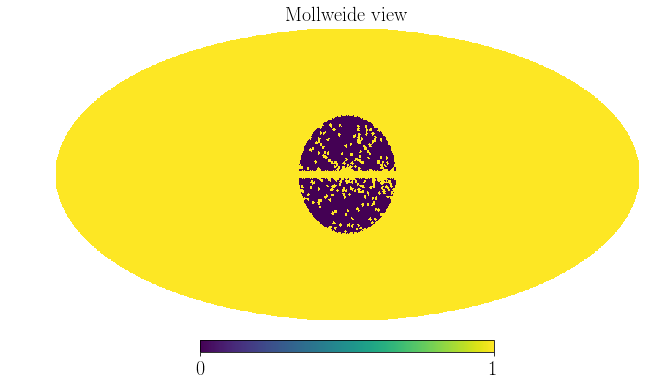

In [21]:
hp.mollview(analysis_mask)

In [22]:
area_factor = np.sum(~analysis_mask)/hp.nside2npix(128)
analysis_mask_upgrade = hp.ud_grade(analysis_mask,2048,power=-2)
srdeg2_sphere = 4*np.pi*np.rad2deg(1)**2

In [23]:
exposure_map = np.ones(len(fermi_exposure))*np.mean(fermi_exposure)

In [24]:
# exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
# exp_masked_compressed = exp_masked.compressed()
# exp_masked_mean = np.mean(exp_masked_compressed)

exp_masked = ma.masked_array(data=exposure_map, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [25]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2

temp_masked_compressed = ma.masked_array(data=nfw*1e-5,mask=analysis_mask)
rf = np.sum(temp_masked_compressed/rescale)*exp_masked_mean/area_mask

## Load data

In [26]:
data_tag = "NFW_PS_below1ph_flat_2048"

In [27]:
MC_dir = "/tigress/ljchang/NPTF-IG-Check/data/simPS/"

In [28]:
MC = 0

In [29]:
# sim_map = np.load(MC_dir+"MCs/with_bkg_components/"+data_tag+"_dif.npy").astype('int32')
sim_map = np.load(MC_dir+"MCs/with_bkg_components/flat_exposure/"+data_tag+"_dif.npy").astype('int32')
# sim_map = np.load(MC_dir+"MCs/with_bkg_components/flat_exposure/varyROI/b_2_r_30/"+data_tag+"_dif_MC"+str(MC)+".npy").astype('int32')
# sim_map = np.load(MC_dir+"MCs/with_bkg_components/flat_exposure/"+data_tag+"_dif_20xdimmer_MC"+str(MC)+".npy").astype('int32')

sim_map_orig = hp.ud_grade(np.load(MC_dir+data_tag+".npz")['flux_map'],128,power=-2)*np.mean(fermi_exposure)
sim_fluxes = np.load(MC_dir+data_tag+".npz")['fluxes']
sim_pixvals = np.load(MC_dir+data_tag+".npz")['pixvals']

In [30]:
# old_MC = np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/NFW_PS_below1ph_flat_2048_dif.npy").astype('int32')
# new_MC = np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/varyROI/b_2_r_30/NFW_PS_below1ph_flat_2048_dif_old.npy").astype('int32')

In [31]:
fluxes_masked = []
for i in range(len(sim_fluxes)):
    if not analysis_mask_upgrade[sim_pixvals[i]]:
        fluxes_masked.append(sim_fluxes[i])

In [32]:
counts, bin_edges = np.histogram(fluxes_masked,bins=np.logspace(-13,-6,60))
bin_centers = np.sqrt(bin_edges[1:]*bin_edges[:-1])
bin_widths = bin_edges[1:]-bin_edges[:-1]

In [33]:
sim_y_counts = counts/(bin_widths*area_factor*srdeg2_sphere)
sim_err_L = (counts-poiss_err(counts,0)[0])/(bin_widths*area_factor*srdeg2_sphere)
sim_err_H = (poiss_err(counts,0)[1]-counts)/(bin_widths*area_factor*srdeg2_sphere)

In [34]:
sim_map_masked_compressed = ma.masked_array(data=sim_map_orig, mask=analysis_mask).compressed()
sim_PS_intens = np.mean(sim_map_masked_compressed/exp_masked_compressed/hp.nside2pixarea(128))

total_flux = np.mean(ma.masked_array(data=sim_map, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))
# total_flux = np.mean(ma.masked_array(data=sim_map, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))

In [35]:
# dif_bf_newroi = np.load(templates_dir+"with_dsk_poiss/dif_band_2_ring_30.npy")
dif_bf_newroi = np.load(templates_dir+"dif_band_2_ring_30.npy")

In [36]:
inj_dif = np.mean(ma.masked_array(data=dif_bf_newroi/rescale, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))

In [37]:
SCD_params = np.load("/tigress/ljchang/NPTF-IG-Check/data/kingPSF_NFW_PS_100_GCE_flux_below1ph_flat.npz")["SCD_params"]

## Load scan

In [39]:
iGCE = 1
psf_king = 1

In [40]:
n = nptfit.NPTF(work_dir="../",tag="mpmath/PS_dif20xdimmer_MC"+str(MC))
# n = nptfit.NPTF(work_dir="../",tag="simple_scans/PS_below1ph_flat_dif/dif_MC"+str(MC))

n.load_data(sim_map, exposure_map)
n.load_mask(analysis_mask)

n.add_template(dif/rescale, 'dif')
# n.add_template(np.ones(len(iso)), 'iso')
n.add_template(iso/rescale, 'iso')
n.add_template(psc/rescale, 'psc')
n.add_template(bub/rescale, 'bub')
n.add_template(nfw_smoothed*0.0002/rescale, 'nfw_dm') # Adjust norm of template such that A=1 corresp. to xsec of ~1e-26

# Adjust PS template norms such that A~1 on data
iso_ps = np.ones(len(iso))
n.add_template(iso_ps*0.07, 'iso_ps',units='PS') 
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(dsk*0.004/rescale, 'dsk_ps', units='PS') 
n.add_template(nfw*1e-5/rescale, 'nfw_ps', units='PS')

In [49]:
# n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
# n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
# n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
# n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
# n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
# n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_poiss_model('dif', '$A_\mathrm{dif}$', [-5,2], True)
# n.add_poiss_model('iso', '$A_\mathrm{iso}$', [-5,2], True)
# n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [-5,2], True)

# n.add_non_poiss_model('iso_ps',
#                   ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
#                   [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
#                   [True,False,False,False,True,True])

# n.add_non_poiss_model('dsk_ps',
#                   ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
#                   [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
#                   [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,5],[2.05,15.],[-3.95,2.95],[-10,1.95],[0.5,3.5],[-1.75,0.5]],
                          [True,False,False,False,True,True])

# if psf_king:
#     print("Using King PSF function")
#     # Define parameters that specify the Fermi-LAT PSF at 2 GeV
#     fcore = 0.748988248179
#     score = 0.428653790656
#     gcore = 7.82363229341
#     stail = 0.715962650769
#     gtail = 3.61883748683
#     spe = 0.00456544262478

#     # Define the full PSF in terms of two King functions
#     def king_fn(x, sigma, gamma):
#         return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

#     def Fermi_PSF(r):
#         return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

#     # Modify the relevant parameters in pc_inst and then make or load the PSF
# #     pc_inst = pc.PSFCorrection(delay_compute=True,num_f_bins=40,f_trunc=0.0025)
# #     pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
# #     pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
# #     pc_inst.psf_samples = 10000
# #     pc_inst.psf_tag = 'Fermi_PSF_2GeV_numfbins_40_ftrunc_0.005'
# #     pc_inst.make_or_load_psf_corr()

#     pc_inst = pc.PSFCorrection(delay_compute=True)
#     pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
#     pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
#     pc_inst.psf_samples = 10000
#     pc_inst.psf_tag = 'Fermi_PSF_2GeV'
#     pc_inst.make_or_load_psf_corr()

#     # Extract f_ary and df_rho_div_f_ary as usual
#     f_ary = pc_inst.f_ary
#     df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
# else:
#     pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
#     f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

# n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)
n.configure_for_scan(nexp=1)


The number of parameters to be fit is 7


In [50]:
n.load_scan()

  analysing data from ../chains/mpmath/PS_dif20xdimmer_MC0/.txt


In [51]:
an = dnds_analysis.Analysis(n)

In [71]:
A_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[0])
n_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[1]).T
Sb_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[2]).T


In [91]:
dNdF_post = np.zeros((len(A_post),len(f_ary0)))

for i in tqdm(range(len(A_post))):
    dNdF_post[i] = [rf*dNdF_2break(A_post[i],n_post[i][0],n_post[i][1],n_post[i][2],Sb_post[i][0]/exp_masked_mean,Sb_post[i][1]/exp_masked_mean,f) for f in f_ary0]

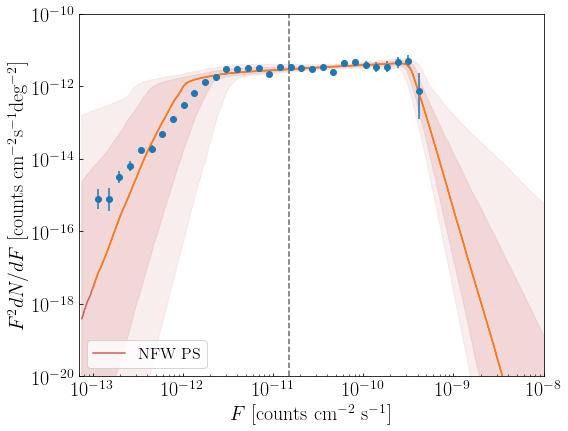

In [93]:
if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.005,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.errorbar(bin_centers,bin_centers**2*sim_y_counts,yerr=bin_centers**2*np.array([sim_err_L,sim_err_H]), fmt='o')

plt.plot(f_ary0,f_ary0**2*np.median(dNdF_post,axis=0))
plt.yscale('log')
plt.xscale('log')
plt.xlim(7e-14,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tick_params(which='both',direction='in')
plt.legend(loc='lower left')

In [75]:
# an.make_triangle()
# plt.savefig('plots/PS_test_MCs/mpmath/PS_only/corner_dif_MC'+str(MC)+'.pdf')

In [45]:
flux_bins = np.logspace(-10,-5,100)

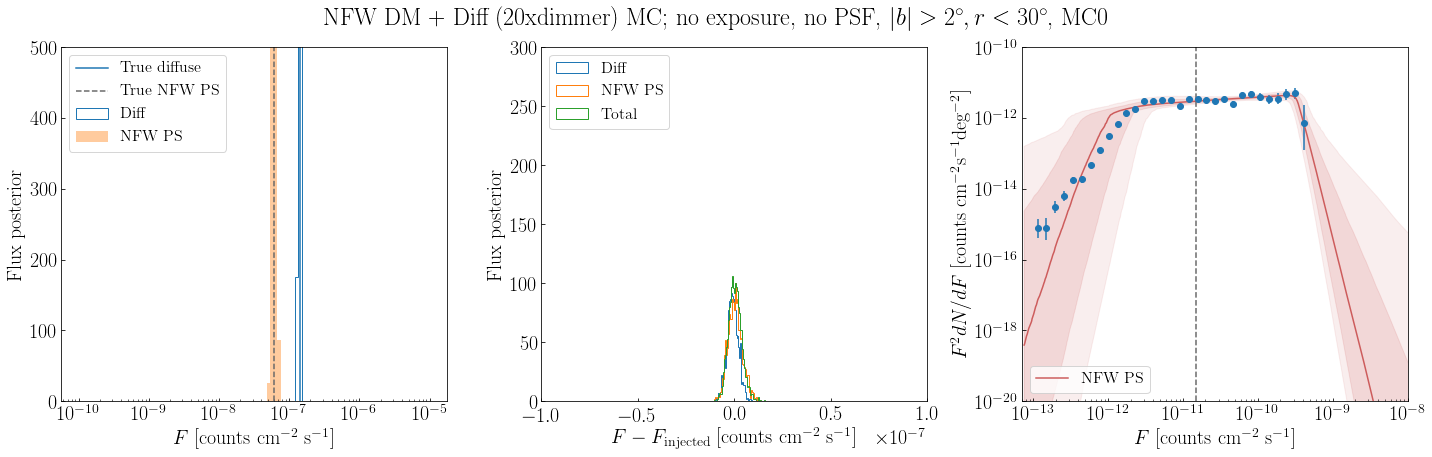

In [47]:
f, ax = plt.subplots(1,3)
f.set_figheight(6)
f.set_figwidth(20)

# an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

# an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.005,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
ax[2].errorbar(bin_centers,bin_centers**2*sim_y_counts,yerr=bin_centers**2*np.array([sim_err_L,sim_err_H]), fmt='o')

ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_xlim(7e-14,1e-8)
ax[2].set_ylim(1e-20,1e-10)
ax[2].axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
ax[2].set_ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
ax[2].set_xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
ax[2].tick_params(which='both',direction='in')
ax[2].legend(loc='lower left')

############################################################################################################

ax[0].hist(an.return_intensity_arrays_poiss('dif'),bins=flux_bins,histtype='step',label='Diff');
# ax[0].hist(an.return_intensity_arrays_poiss('iso'),bins=flux_bins,histtype='step',label='Iso');
# ax[0].hist(an.return_intensity_arrays_poiss('psc'),bins=flux_bins,histtype='step',label='3FGL');
# ax[0].hist(an.return_intensity_arrays_poiss('bub'),bins=flux_bins,histtype='step',label='Bub');
# ax[0].hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=flux_bins,histtype='step',label='NFW');

# ax[0].hist(an.return_intensity_arrays_non_poiss('iso_ps'),bins=flux_bins,histtype='stepfilled',alpha=.4,label='Iso PS');
# ax[0].hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=flux_bins,histtype='stepfilled',alpha=.4,label='Disk PS');
if GCE_options[iGCE]:
    ax[0].hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=flux_bins,histtype='stepfilled', alpha=.4, label='NFW PS');
ax[0].set_xscale('log')
ax[0].set_ylim(0,500)
ax[0].set_xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
ax[0].set_ylabel('Flux posterior')
ax[0].tick_params(which='both',direction='in')

ax[0].axvline(inj_dif,label='True diffuse')
ax[0].axvline(sim_PS_intens,label='True NFW PS',color='dimgray',ls='--')
ax[0].legend(loc='upper left')

############################################################################################################

ax[1].hist(np.array(an.return_intensity_arrays_poiss('dif'))-inj_dif,bins=50,histtype='step',label='Diff');
ax[1].hist(np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-sim_PS_intens,bins=50,histtype='step',label='NFW PS');
ax[1].hist(np.array(an.return_intensity_arrays_poiss('dif'))+np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-total_flux,bins=50,histtype='step',label='Total');

ax[1].set_xlim(-1e-7,1e-7) 
ax[1].set_ylim(0,300)
ax[1].set_xlabel('$F-F_\mathrm{injected}$  [counts cm$^{-2}$ s$^{-1}$]')
ax[1].set_ylabel('Flux posterior')
ax[1].tick_params(which='both',direction='in')
ax[1].legend(loc='upper left')

f.tight_layout()

sup = f.suptitle(r'NFW DM + Diff (20xdimmer) MC; no exposure, no PSF, '+r'$|b|>2^\circ,r<30^\circ$, MC'+str(MC),y=1.05,fontsize=24);
plt.savefig('plots/PS_test_MCs/mpmath/PS_dif_20xdimmer/PS_dif20xdimmer_MC'+str(MC)+'.pdf',bbox_extra_artists=(sup,), bbox_inches="tight")

# sup = f.suptitle(r'NFW DM + Diff MC; no exposure, no PSF, '+r'$|b|>2^\circ,r<15^\circ$, MC'+str(MC),y=1.05,fontsize=24);
# plt.savefig('plots/PS_test_MCs/mpmath/dif_MC'+str(MC)+'.pdf',bbox_extra_artists=(sup,), bbox_inches="tight")


In [38]:
iGCE = 1
psf_king = 1

In [40]:
dNdF_post_MCs = []
dif_flux_post_MCs = []
NFWPS_flux_post_MCs = []
total_flux_post_MCs = []

for MC in tqdm(range(44,50)):
# for MC in [49]:
    sim_map = np.load(MC_dir+"MCs/with_bkg_components/flat_exposure/"+data_tag+"_dif_MC"+str(MC)+".npy").astype('int32')
    total_flux = np.mean(ma.masked_array(data=sim_map, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))

    n = nptfit.NPTF(work_dir="../",tag="mpmath/PS_dif_MC"+str(MC))
    # n = nptfit.NPTF(work_dir="../",tag="simple_scans/PS_below1ph_flat_dif/dif_MC"+str(MC))

    n.load_data(sim_map, exposure_map)
    n.load_mask(analysis_mask)

    n.add_template(dif/rescale, 'dif')
    # n.add_template(np.ones(len(iso)), 'iso')
    n.add_template(iso/rescale, 'iso')
    n.add_template(psc/rescale, 'psc')
    n.add_template(bub/rescale, 'bub')
    n.add_template(nfw_smoothed*0.0002/rescale, 'nfw_dm') # Adjust norm of template such that A=1 corresp. to xsec of ~1e-26

    # Adjust PS template norms such that A~1 on data
    iso_ps = np.ones(len(iso))
    n.add_template(iso_ps*0.07, 'iso_ps',units='PS') 
    # Remove the exposure correction for PS templates
    rescale = fermi_exposure/np.mean(fermi_exposure)
    n.add_template(dsk*0.004/rescale, 'dsk_ps', units='PS') 
    n.add_template(nfw*1e-5/rescale, 'nfw_ps', units='PS')
    
    n.add_poiss_model('dif', '$A_\mathrm{dif}$', [-5,2], True)

    if GCE_options[iGCE]:
        n.add_non_poiss_model('nfw_ps',
                              ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                              [[-10,5],[2.05,15.],[-3.95,2.95],[-10,1.95],[0.5,3.5],[-1.75,0.5]],
                              [True,False,False,False,True,True])

#     if psf_king:
#         print("Using King PSF function")
#         # Define parameters that specify the Fermi-LAT PSF at 2 GeV
#         fcore = 0.748988248179
#         score = 0.428653790656
#         gcore = 7.82363229341
#         stail = 0.715962650769
#         gtail = 3.61883748683
#         spe = 0.00456544262478

#         # Define the full PSF in terms of two King functions
#         def king_fn(x, sigma, gamma):
#             return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

#         def Fermi_PSF(r):
#             return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

#         # Modify the relevant parameters in pc_inst and then make or load the PSF
#     #     pc_inst = pc.PSFCorrection(delay_compute=True,num_f_bins=40,f_trunc=0.0025)
#     #     pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
#     #     pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
#     #     pc_inst.psf_samples = 10000
#     #     pc_inst.psf_tag = 'Fermi_PSF_2GeV_numfbins_40_ftrunc_0.005'
#     #     pc_inst.make_or_load_psf_corr()

#         pc_inst = pc.PSFCorrection(delay_compute=True)
#         pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
#         pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
#         pc_inst.psf_samples = 10000
#         pc_inst.psf_tag = 'Fermi_PSF_2GeV'
#         pc_inst.make_or_load_psf_corr()

#         # Extract f_ary and df_rho_div_f_ary as usual
#         f_ary = pc_inst.f_ary
#         df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
#     else:
#         pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
#         f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

#     n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)
    n.configure_for_scan(nexp=1)
    n.load_scan()

    an = dnds_analysis.Analysis(n)
    
    A_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[0])
    n_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[1]).T
    Sb_post = np.array(an.return_non_poiss_parameter_posteriors('nfw_ps')[2]).T

    dNdF_post = np.zeros((len(A_post),len(f_ary0)))

    for i in tqdm(range(len(A_post))):
        dNdF_post[i] = [rf*dNdF_2break(A_post[i],n_post[i][0],n_post[i][1],n_post[i][2],Sb_post[i][0]/exp_masked_mean,Sb_post[i][1]/exp_masked_mean,f) for f in f_ary0]
    dNdF_post_MCs.append(dNdF_post)
    
    dif_flux_post_MCs.append(np.array(an.return_intensity_arrays_poiss('dif'))-inj_dif)
    NFWPS_flux_post_MCs.append(np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-sim_PS_intens)
    total_flux_post_MCs.append(np.array(an.return_intensity_arrays_poiss('dif'))+np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-total_flux)

The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC44/.txt


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC45/.txt


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC46/.txt


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC47/.txt


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC48/.txt


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC49/.txt


In [62]:
dNdF_post_MCs_medians = [np.median(dNdF_post_MCs[i],axis=0) for i in range(len(dNdF_post_MCs))]

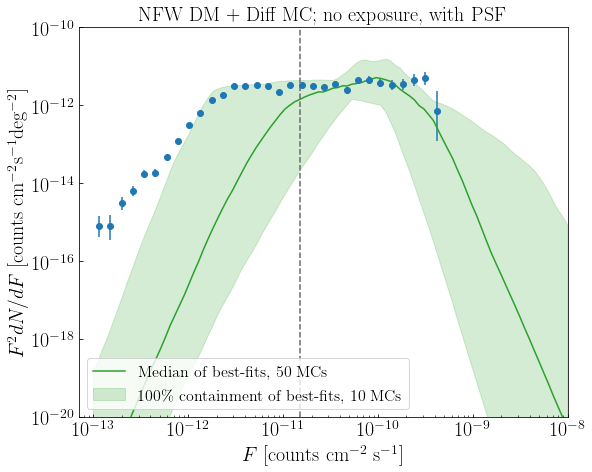

In [63]:
# if GCE_options[iGCE]:
#     an.plot_source_count_median('nfw_ps',smin=0.005,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
#     an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
#     an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.errorbar(bin_centers,bin_centers**2*sim_y_counts,yerr=bin_centers**2*np.array([sim_err_L,sim_err_H]), fmt='o')

plt.plot(f_ary0,f_ary0**2*np.median(dNdF_post_MCs_medians,axis=0),color='C2',label='Median of best-fits, 50 MCs')
plt.fill_between(f_ary0,f_ary0**2*np.percentile(dNdF_post_MCs_medians,axis=0,q=0),f_ary0**2*np.percentile(dNdF_post_MCs_medians,axis=0,q=100),alpha=.2,color='C2',label='100\% containment of best-fits, 10 MCs')

# plt.plot(f_ary0,f_ary0**2*dNdF_post_MCs_medians[1])

plt.yscale('log')
plt.xscale('log')
plt.xlim(7e-14,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tick_params(which='both',direction='in')
plt.title(r'NFW DM + Diff MC; no exposure, with PSF')
plt.legend(loc='lower left')
plt.tight_layout()

In [ ]:
for MC in tqdm(range(10)):
# for MC in [14]:
    sim_map = np.load(MC_dir+"MCs/with_bkg_components/flat_exposure/"+data_tag+"_dif_MC"+str(MC)+".npy").astype('int32')

    sim_map_orig = hp.ud_grade(np.load(MC_dir+data_tag+".npz")['flux_map'],128,power=-2)*np.mean(fermi_exposure)
    sim_fluxes = np.load(MC_dir+data_tag+".npz")['fluxes']
    sim_pixvals = np.load(MC_dir+data_tag+".npz")['pixvals']

    fluxes_masked = []
    for i in range(len(sim_fluxes)):
        if not analysis_mask_upgrade[sim_pixvals[i]]:
            fluxes_masked.append(sim_fluxes[i])

    counts, bin_edges = np.histogram(fluxes_masked,bins=np.logspace(-13,-6,60))
    bin_centers = np.sqrt(bin_edges[1:]*bin_edges[:-1])
    bin_widths = bin_edges[1:]-bin_edges[:-1]

    sim_y_counts = counts/(bin_widths*area_factor*srdeg2_sphere)
    sim_err_L = (counts-poiss_err(counts,0)[0])/(bin_widths*area_factor*srdeg2_sphere)
    sim_err_H = (poiss_err(counts,0)[1]-counts)/(bin_widths*area_factor*srdeg2_sphere)

    sim_map_masked_compressed = ma.masked_array(data=sim_map_orig, mask=analysis_mask).compressed()
    sim_PS_intens = np.mean(sim_map_masked_compressed/exp_masked_compressed/hp.nside2pixarea(128))

    total_flux = np.mean(ma.masked_array(data=sim_map, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))
    # total_flux = np.mean(ma.masked_array(data=sim_map, mask=analysis_mask).compressed()/exp_masked_compressed/hp.nside2pixarea(128))

    n = nptfit.NPTF(work_dir="../",tag="mpmath/PS_dif_MC"+str(MC))
    # n = nptfit.NPTF(work_dir="../",tag="simple_scans/PS_below1ph_flat_dif/dif_MC"+str(MC))

    n.load_data(sim_map, exposure_map)
    n.load_mask(analysis_mask)

    n.add_template(dif/rescale, 'dif')
    # n.add_template(np.ones(len(iso)), 'iso')
    n.add_template(iso/rescale, 'iso')
    n.add_template(psc/rescale, 'psc')
    n.add_template(bub/rescale, 'bub')
    n.add_template(nfw_smoothed*0.0002/rescale, 'nfw_dm') # Adjust norm of template such that A=1 corresp. to xsec of ~1e-26

    # Adjust PS template norms such that A~1 on data
    iso_ps = np.ones(len(iso))
    n.add_template(iso_ps*0.07, 'iso_ps',units='PS') 
    # Remove the exposure correction for PS templates
    rescale = fermi_exposure/np.mean(fermi_exposure)
    n.add_template(dsk*0.004/rescale, 'dsk_ps', units='PS') 
    n.add_template(nfw*1e-5/rescale, 'nfw_ps', units='PS')

    # n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
    # n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
    # n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
    # n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
    # n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
    # n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

    n.add_poiss_model('dif', '$A_\mathrm{dif}$', [-5,2], True)
    # n.add_poiss_model('iso', '$A_\mathrm{iso}$', [-5,2], True)
    # n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [-5,2], True)

    # n.add_non_poiss_model('iso_ps',
    #                   ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
    #                   [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
    #                   [True,False,False,False,True,True])

    # n.add_non_poiss_model('dsk_ps',
    #                   ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
    #                   [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
    #                   [True,False,False,False,True,True])

    if GCE_options[iGCE]:
        n.add_non_poiss_model('nfw_ps',
                              ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                              [[-10,5],[2.05,15.],[-3.95,2.95],[-10,1.95],[0.5,3.5],[-1.75,0.5]],
                              [True,False,False,False,True,True])

#     if psf_king:
#         print("Using King PSF function")
#         # Define parameters that specify the Fermi-LAT PSF at 2 GeV
#         fcore = 0.748988248179
#         score = 0.428653790656
#         gcore = 7.82363229341
#         stail = 0.715962650769
#         gtail = 3.61883748683
#         spe = 0.00456544262478

#         # Define the full PSF in terms of two King functions
#         def king_fn(x, sigma, gamma):
#             return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

#         def Fermi_PSF(r):
#             return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

#         # Modify the relevant parameters in pc_inst and then make or load the PSF
#     #     pc_inst = pc.PSFCorrection(delay_compute=True,num_f_bins=40,f_trunc=0.0025)
#     #     pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
#     #     pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
#     #     pc_inst.psf_samples = 10000
#     #     pc_inst.psf_tag = 'Fermi_PSF_2GeV_numfbins_40_ftrunc_0.005'
#     #     pc_inst.make_or_load_psf_corr()

#         pc_inst = pc.PSFCorrection(delay_compute=True)
#         pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
#         pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
#         pc_inst.psf_samples = 10000
#         pc_inst.psf_tag = 'Fermi_PSF_2GeV'
#         pc_inst.make_or_load_psf_corr()

#         # Extract f_ary and df_rho_div_f_ary as usual
#         f_ary = pc_inst.f_ary
#         df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
#     else:
#         pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
#         f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

#     n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)
    n.configure_for_scan(nexp=1)
    n.load_scan()

    an = dnds_analysis.Analysis(n)

    f, ax = plt.subplots(1,3)
    f.set_figheight(6)
    f.set_figwidth(20)

    # an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
    # an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
    # an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

    # an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
    # an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
    # an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

    if GCE_options[iGCE]:
        an.plot_source_count_median('nfw_ps',smin=0.005,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
        an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
        an.plot_source_count_band('nfw_ps',smin=0.005,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
    ax[2].errorbar(bin_centers,bin_centers**2*sim_y_counts,yerr=bin_centers**2*np.array([sim_err_L,sim_err_H]), fmt='o')

    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].set_xlim(7e-14,1e-8)
    ax[2].set_ylim(1e-20,1e-10)
    ax[2].axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
    ax[2].set_ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
    ax[2].set_xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
    ax[2].tick_params(which='both',direction='in')
    ax[2].legend(loc='lower left')

    ############################################################################################################

    ax[0].hist(an.return_intensity_arrays_poiss('dif'),bins=flux_bins,histtype='step',label='Diff');
    # ax[0].hist(an.return_intensity_arrays_poiss('iso'),bins=flux_bins,histtype='step',label='Iso');
    # ax[0].hist(an.return_intensity_arrays_poiss('psc'),bins=flux_bins,histtype='step',label='3FGL');
    # ax[0].hist(an.return_intensity_arrays_poiss('bub'),bins=flux_bins,histtype='step',label='Bub');
    # ax[0].hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=flux_bins,histtype='step',label='NFW');

    # ax[0].hist(an.return_intensity_arrays_non_poiss('iso_ps'),bins=flux_bins,histtype='stepfilled',alpha=.4,label='Iso PS');
    # ax[0].hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=flux_bins,histtype='stepfilled',alpha=.4,label='Disk PS');
    if GCE_options[iGCE]:
        ax[0].hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=flux_bins,histtype='stepfilled', alpha=.4, label='NFW PS');
    ax[0].set_xscale('log')
    ax[0].set_ylim(0,500)
    ax[0].set_xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
    ax[0].set_ylabel('Flux posterior')
    ax[0].tick_params(which='both',direction='in')

    ax[0].axvline(inj_dif,label='True diffuse')
    ax[0].axvline(sim_PS_intens,label='True NFW PS',color='dimgray',ls='--')
    ax[0].legend(loc='upper left')

    ############################################################################################################

    ax[1].hist(np.array(an.return_intensity_arrays_poiss('dif'))-inj_dif,bins=50,histtype='step',label='Diff');
    ax[1].hist(np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-sim_PS_intens,bins=50,histtype='step',label='NFW PS');
    ax[1].hist(np.array(an.return_intensity_arrays_poiss('dif'))+np.array(an.return_intensity_arrays_non_poiss('nfw_ps'))-total_flux,bins=50,histtype='step',label='Total');

    ax[1].set_xlim(-1e-7,1e-7) 
    ax[1].set_ylim(0,300)
    ax[1].set_xlabel('$F-F_\mathrm{injected}$  [counts cm$^{-2}$ s$^{-1}$]')
    ax[1].set_ylabel('Flux posterior')
    ax[1].tick_params(which='both',direction='in')
    ax[1].legend(loc='upper left')

    f.tight_layout()

    sup = f.suptitle(r'NFW DM + Diff MC; no exposure, no PSF, '+r'$|b|>2^\circ,r<30^\circ$, MC'+str(MC),y=1.05,fontsize=24);
    plt.savefig('plots/PS_test_MCs/mpmath/PS_dif/PS_dif_MC'+str(MC)+'.pdf',bbox_extra_artists=(sup,), bbox_inches="tight")

    # sup = f.suptitle(r'NFW DM + Diff MC; no exposure, no PSF, '+r'$|b|>2^\circ,r<15^\circ$, MC'+str(MC),y=1.05,fontsize=24);
    # plt.savefig('plots/PS_test_MCs/mpmath/dif_MC'+str(MC)+'.pdf',bbox_extra_artists=(sup,), bbox_inches="tight")


The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC14/.txt
The number of parameters to be fit is 7
  analysing data from ../chains/mpmath/PS_dif_MC15/.txt


In [131]:
# for MC in range(10):
#     hp.mollview(np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/varyROI/b_2_r_30/"+data_tag+"_dif_MC"+str(MC)+".npy"))
#     plt.savefig('plots/PS_test_MCs/MCmap_'+str(MC)+'.pdf')

In [212]:
map4 = np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/varyROI/b_2_r_30/"+data_tag+"_dif_MC4.npy")
map5 = np.load("/tigress/ljchang/NPTF-IG-Check/data/simPS/MCs/with_bkg_components/flat_exposure/king_smoothed/varyROI/b_2_r_30/"+data_tag+"_dif_MC5.npy")

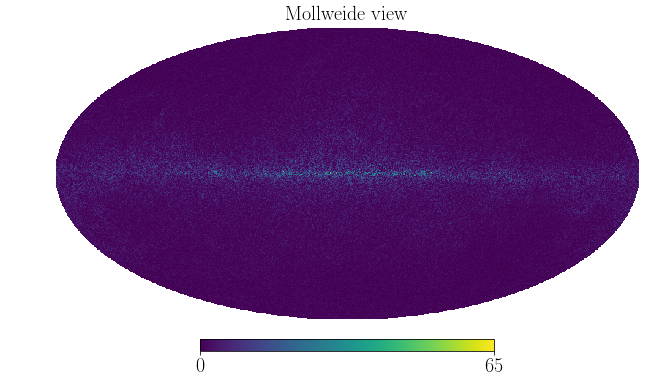

In [214]:
hp.mollview(np.abs(map4-map5))